# M10: Naïve Bayes Text Classification
# DAV 6150

- Group Members: Qing Dou, Ruoyu Chen, Zhengnan Li
- Repository: https://github.com/jc000222/Data_Science_DAV6150/tree/main/M10

In [1]:
import pandas as pd
import requests
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import string
from nltk.stem import WordNetLemmatizer
import re
from collections import Counter
# nltk.download('stopwords')

# 1 Introduction
The task for the Module 10 Assignment is to construct a Naïve Bayes sentiment classifier for purposes of gauging the sentiment of movie reviews. 
### 1.1 Approach:
- [Introduction](#1-introduction): Summarize the problem and introduce data.

- [Data Preparation](#2-data-preparation): Import and transform the data set into properly labeled count vectors within a Term-Document matrix.

- [Frequency Distribution Plots](#3-frequency-distribution-plots): Explain and present the word count frequency distribution plots.

- [Naïve Bayes Model Training](#4-naïve-bayes-model-training): Separated the count vectors into training and testing subsets, Explain and present the Naïve Bayes classifier modeling work and types of Naïve Bayes classifier.

- [Model Testing](#5-model-testing): Apply your model to the testing subset and discuss your results.

- [Conclusions](#6-conclusions)


### 1.2 Data Introduction
The data set we will be working with is sourced from this site: http://www.cs.cornell.edu/people/pabo/movie-review-data/.   
Specifically, we will be working with the polarity dataset v2.0, which is comprised of 1000 positive and 1000 negative movie reviews. Each movie review is in the form of free-form text captured from web site postings. To complete this assignment we will need to make use of a fair amount of pre-processing techniques to prepare the content of the reviews for use within a classification model (e.g., strip out punctuation, stop words, etc.). Each line in each text file corresponds to a single sentence, as  determined by Adwait Ratnaparkhi's sentence boundary detector MXTERMINATOR.

# 2 Data Preparation
In this section we will load the data from github repository. The data provided is organize as below:  

__txt_sentoken__
- neg
    - cv000_29416.txt
    - cv001_23236.txt
    - ...
- pos
    - cv000_29444.txt
    - cv001_14514.txt
    - ... 

We use a loop and some function to read the negative review text files into a 'review_neg' dataframe and the positive review text files into a 'review_pos' dataframe. And concat the two files into a new dataframe.

In [2]:
def get_file_names(sentiment):
    url = f"https://api.github.com/repositories/749244377/contents/M10/txt_sentoken/{sentiment}"
    response = requests.get(url)
    if response.status_code == 200:
        files = response.json()
        txt_files = [file['download_url'] for file in files if file['type'] == 'file' and file['name'].endswith('.txt')]
        return txt_files
    else:
        print(f"Failed to fetch directory contents. Status code: {response.status_code}")

def read_file(file_url):
    try:
        response = requests.get(file_url)
        if response.status_code == 200:
            return response.text
        else:
            print(f"Failed to fetch file from URL: {file_url}. Status code: {response.status_code}")
            return None
    except Exception as e:
        print(f"Error fetching file from URL: {file_url}. Exception: {e}")

def get_df(sentiment):
    rows = []
    file_names = get_file_names(sentiment)

    with ThreadPoolExecutor(max_workers=15) as executor, tqdm(total=len(file_names), desc=f'Reading {sentiment} files') as pbar:
        file_contents = executor.map(read_file, file_names)
        for content in file_contents:
            if content is not None:
                rows.append(content)
                pbar.update(1)
    if sentiment == 'neg':
        df = pd.DataFrame({'text': rows, 'sentiment': 0})
    else:
        df = pd.DataFrame({'text': rows, 'sentiment': 1})
    return df
    
review_neg = get_df("neg")
review_pos = get_df("pos")

review = pd.concat([review_neg, review_pos], ignore_index=True)
review.head()

Reading neg files:  31%|███       | 311/1000 [00:37<01:23,  8.26it/s]


KeyboardInterrupt: 

Remove stop words and non-alphabetic characters from text. Use Lemmatization to converting the word to its base form or lemma by removing affixes from the inflected words. It helps to create better features for machine learning and NLP models hence it is an important preprocessing step.

In [ ]:
def cleaner(text):
    letters_only_text = re.sub("[^a-z]", " ", text)
    words = nltk.word_tokenize(letters_only_text)
    
    # Remove punctuation
    words_cleaned = [word for word in words if word not in string.punctuation]

    # Remove stop words
    stop_words = stopwords.words('english')
    words_cleaned = [word for word in words_cleaned if word.lower() not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words_cleaned = [lemmatizer.lemmatize(word) for word in words_cleaned ] 
    
    return " ".join(words_cleaned)

review['cleaned_text'] = review['text'].apply(cleaner)
review.head()

,text,sentiment,cleaned_text
0,"plot : two teen couples go to a church party ,...",0,plot two teen couple go church party drink dri...
1,the happy bastard's quick movie review \ndamn ...,0,happy bastard quick movie review damn k bug go...
2,it is movies like these that make a jaded movi...,0,movie like make jaded movie viewer thankful in...
3,""" quest for camelot "" is warner bros . ' firs...",0,quest camelot warner bros first feature length...
4,synopsis : a mentally unstable man undergoing ...,0,synopsis mentally unstable man undergoing psyc...


Show the most Frequent Words

In [ ]:
cnt = Counter()
for text in review["cleaned_text"].values:
    for word in text.split():
        cnt[word] += 1
cnt.most_common(10)

[('film', 11055),
 ('movie', 6981),
 ('one', 6030),
 ('character', 3879),
 ('like', 3790),
 ('time', 2979),
 ('get', 2814),
 ('scene', 2671),
 ('make', 2634),
 ('even', 2568)]

## 3. Frequency Distribution Plots

First, we compare the length of positive and negative movie reviews.
we can observe that the range of word for positive review are bigger than the range of negative review. This means that in some cases, people give long comments for excellent movies, but they may be less critical of bad movies.

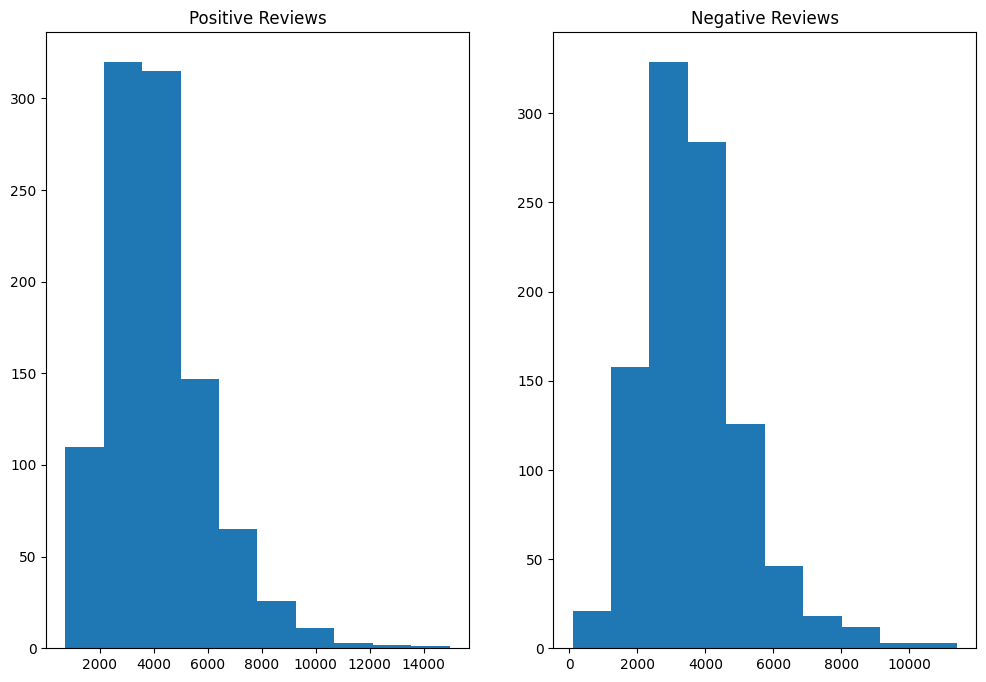

In [ ]:
import matplotlib.pyplot as plt

# Create histograms comparing the length of positive and negative movie reviews.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

# The positive
ax1.hist(review[review['sentiment'] == 1]['text'].str.len())
ax1.set_title('Positive Reviews')

# The negative
ax2.hist(review[review['sentiment'] == 0]['text'].str.len())
ax2.set_title('Negative Reviews')

plt.show()


Next，we will make bar plots and word cloud graphs to show the 30 most used words in positive reviews and negative reviews.

##### Positive reviews

In [ ]:
# Aggregating word frequencies from the document-feature matrix based on sentiment.
positive_docs = review[review['sentiment'] == 1]['cleaned_text']
negative_docs = review[review['sentiment'] == 0]['cleaned_text']
def aggregate_word_frequencies(docs):
    """Aggregates word frequencies from a list of documents."""
    all_words = []
    for doc in docs:
        doc = doc.split(' ')
        for word in doc:
            all_words.append(word)
    return FreqDist(all_words)

# Compute word frequencies for positive documents.
freq_pos = aggregate_word_frequencies(positive_docs)
top30_pos = freq_pos.most_common(30)
top30_pos[:5]

[('film', 6116),
 ('movie', 3163),
 ('one', 3156),
 ('character', 2064),
 ('like', 1849)]

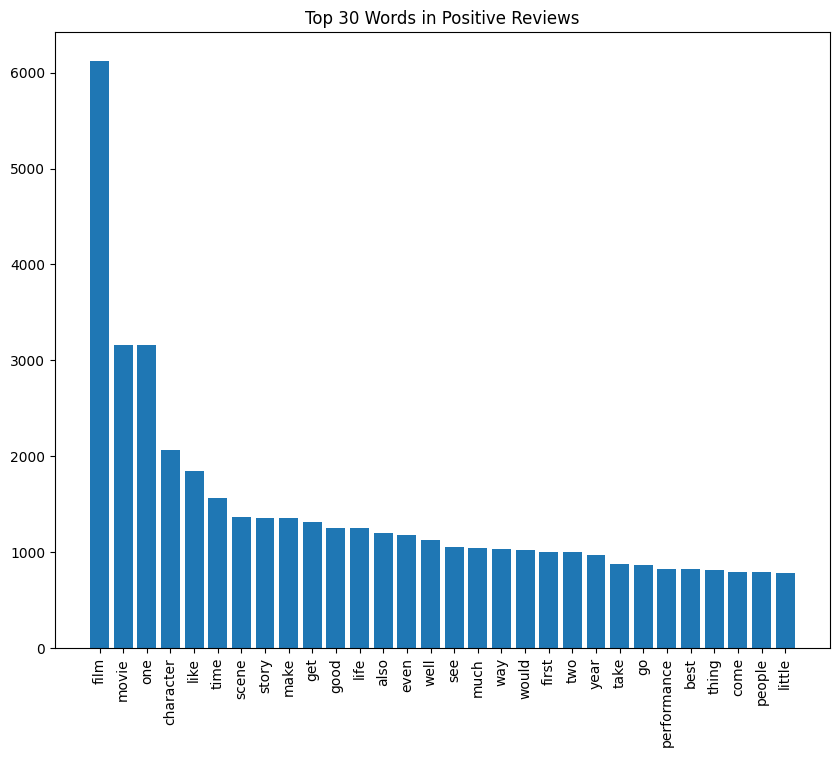

In [ ]:
def plot_word_frequencies(word_freqs, title):
    """Plot bar graph of word frequencies."""
    plt.figure(figsize=(10, 8))
    words, frequencies = zip(*word_freqs)
    plt.bar(words, frequencies)
    plt.xticks(rotation=90) 
    plt.title(title)
    plt.show()

# Plot the top 30 words in positive reviews.
plot_word_frequencies(top30_pos, "Top 30 Words in Positive Reviews")


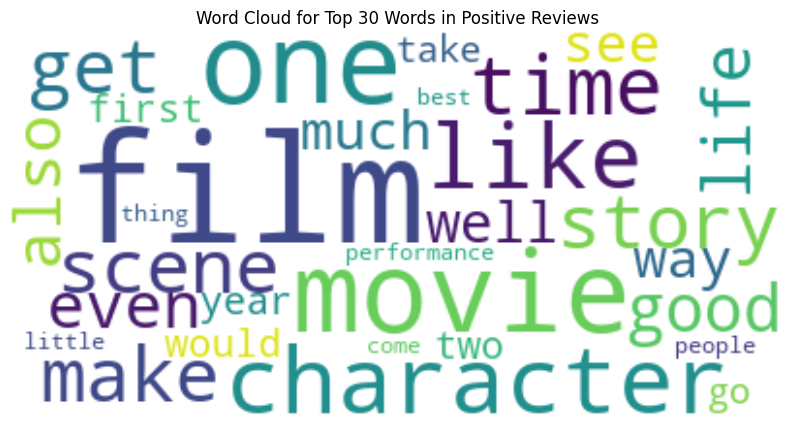

In [ ]:
from wordcloud import WordCloud

# Create word clouds for the top 30 most frequent words in positive reviews.
top30_pos_dict = dict(top30_pos)

# Word cloud for positive reviews
wordcloud_pos = WordCloud(background_color="white").generate_from_frequencies(top30_pos_dict)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Top 30 Words in Positive Reviews")
plt.show()

#### Negative reviews

In [ ]:
# Compute word frequencies for negative documents.
freq_neg = aggregate_word_frequencies(negative_docs)
top30_neg = freq_neg.most_common(30)
top30_neg[:5]

[('film', 4939),
 ('movie', 3818),
 ('one', 2874),
 ('like', 1941),
 ('character', 1815)]

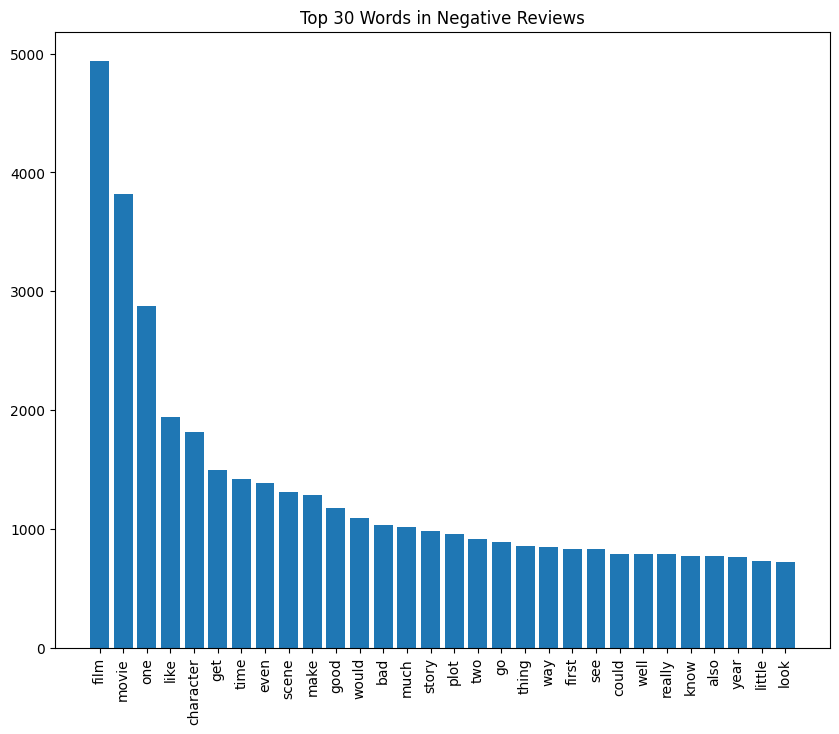

In [ ]:
# Plot the top 30 words in negative reviews.
plot_word_frequencies(top30_neg, "Top 30 Words in Negative Reviews")

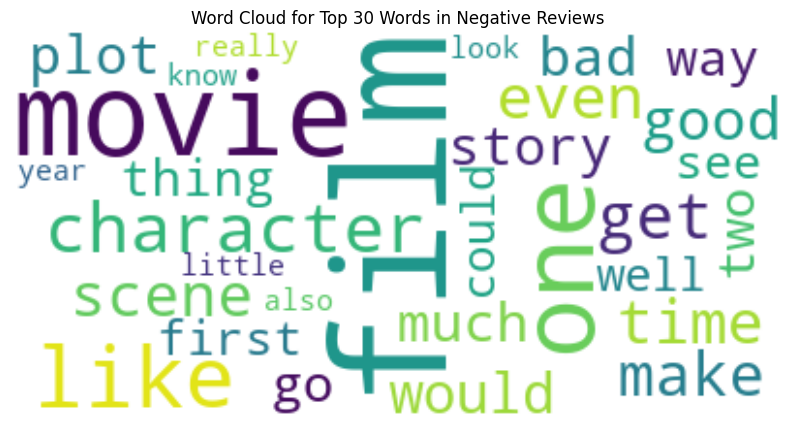

In [ ]:
# Word cloud for negative reviews
top30_neg_dict = dict(top30_neg)
wordcloud_neg = WordCloud(background_color="white").generate_from_frequencies(top30_neg_dict)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Top 30 Words in Negative Reviews")
plt.show()


From the results, we can infer that:
- There are many same words in the two reviews, such as "film", "one", "movie", and "time". These words are common vocabulary used when evaluating movies, and they are not enough to express a clear sentiment orientation.
- In the most frequently words in positive reviews, we can see more positive words like, good, much, well, best, really, which show the high praise for the movie.
- In the most frequently words in the negative reviews, we can see more negative word like bad, little, never, which show the negative fot the movie. Although there are words like good, well, they are possibly used in a negative context, such as not good, not well.

## 4. Naïve Bayes Model Training
In this section, we will use the NaiveBayesClassifier of the nltk library and the BernoulliNB and MultinomialNB modeling in scikit-learn to compare the results and usage differences of the two methods.

In [ ]:
from nltk import NaiveBayesClassifier
from nltk import classify 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve

- ### BernoulliNB

In [ ]:
# create the cleaned data for the train-test split:
nb=review.drop(columns=['text','cleaned_text'])
nb.columns=['sentiment','review']
nb.sentiment = [0 if each == "neg" else 1 for each in nb.sentiment]
nb

,sentiment,review
0,0,plot two teen couples go church party drink dr...
1,0,happy bastard quick movie review damn k bug go...
2,0,movies like make jaded movie viewer thankful i...
3,0,quest camelot warner bros first feature length...
4,0,synopsis mentally unstable man undergoing psyc...
...,...,...
1995,1,wow movie everything movie funny dramatic inte...
1996,1,richard gere commanding actor always great fil...
1997,1,glory starring matthew broderick denzel washin...
1998,1,steven spielberg second epic film world war ii...


In [ ]:
token = RegexpTokenizer(r'[a-z]+')
cv = CountVectorizer(stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts = cv.fit_transform(review['cleaned_text'])
print(text_counts)

d:\conda\envs\AP\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


  (0, 22652)	1
  (0, 30108)	4
  (0, 6391)	1
  (0, 4995)	1
  (0, 21780)	1
  (0, 8779)	1
  (0, 8788)	1
  (0, 159)	1
  (0, 13057)	1
  (0, 8996)	1
  (0, 12288)	1
  (0, 6085)	1
  (0, 17371)	1
  (0, 20383)	2
  (0, 7139)	1
  (0, 33087)	1
  (0, 19747)	7
  (0, 28168)	1
  (0, 6630)	1
  (0, 19183)	3
  (0, 11734)	2
  (0, 12091)	1
  (0, 30842)	1
  (0, 6185)	2
  (0, 14475)	2
  :	:
  (1999, 31034)	1
  (1999, 33282)	1
  (1999, 1432)	1
  (1999, 20127)	1
  (1999, 22137)	1
  (1999, 3850)	4
  (1999, 13905)	2
  (1999, 12011)	2
  (1999, 20328)	4
  (1999, 3604)	1
  (1999, 31541)	1
  (1999, 5646)	1
  (1999, 17529)	1
  (1999, 27831)	1
  (1999, 21367)	1
  (1999, 21620)	1
  (1999, 32374)	1
  (1999, 27952)	1
  (1999, 20790)	1
  (1999, 20760)	1
  (1999, 29947)	1
  (1999, 30581)	1
  (1999, 23007)	1
  (1999, 16440)	1
  (1999, 4207)	1


In [ ]:
X=text_counts
y=review['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=30)

In [ ]:
BNB = BernoulliNB()
BNB.fit(X_train, y_train)

predicted = BNB.predict(X_test)
accuracy_score_bnb = metrics.accuracy_score(predicted,y_test)

print('BernoulliNB model accuracy = ' + str('{:4.2f}'.format(accuracy_score_bnb*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, predicted)))
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, predicted))

BernoulliNB model accuracy = 76.60%
------------------------------------------------
Confusion Matrix:
     0    1
0  209   20
1   97  174
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.91      0.78       229
           1       0.90      0.64      0.75       271

    accuracy                           0.77       500
   macro avg       0.79      0.78      0.76       500
weighted avg       0.80      0.77      0.76       500



- ### MultinomialNB

In [ ]:
MNB = MultinomialNB()
MNB.fit(X_train, y_train)

predicted = MNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, y_test)

print('MultinominalNB model accuracy is',str('{:04.2f}'.format(accuracy_score*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, predicted)))
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, predicted))

MultinominalNB model accuracy is 82.00%
------------------------------------------------
Confusion Matrix:
     0    1
0  203   26
1   64  207
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.89      0.82       229
           1       0.89      0.76      0.82       271

    accuracy                           0.82       500
   macro avg       0.82      0.83      0.82       500
weighted avg       0.83      0.82      0.82       500



## 5. Model Testing 

In [ ]:
from nltk import NaiveBayesClassifier, classify
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, auc

When using nltk's NaiveBayesClassifier, we need to obtain the model's predicted probability for each category. However, nltk's NaiveBayesClassifier does not directly provide a convenient way to obtain predicted probabilities or scores. This is because it is mainly designed for text classification, not probabilistic prediction. So we only display its relevant indicators without drawing the ROC curve

0.8898709292769782 0.8932709196087594


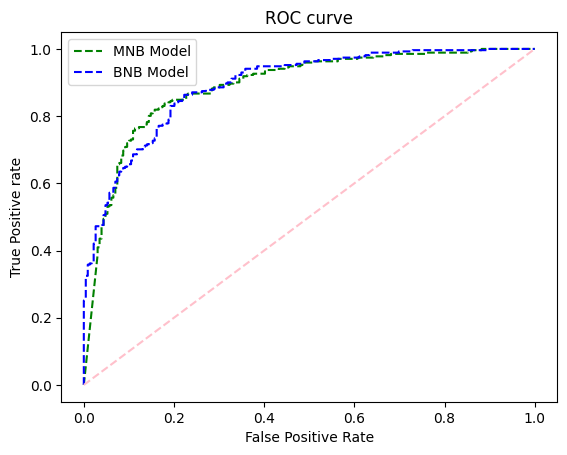

In [ ]:
# predict probabilities for MNB, BNB models: 
MNB_prob = MNB.predict_proba(X_test)
BNB_prob = BNB.predict_proba(X_test)

# roc curve for models
fpr2, tpr2, thresh2 = roc_curve(y_test, MNB_prob[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, BNB_prob[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)


# auc scores
from sklearn.metrics import roc_auc_score
auc_MNB = roc_auc_score(y_test, MNB_prob[:,1])
auc_BNB = roc_auc_score(y_test, BNB_prob[:,1])
print(auc_MNB,auc_BNB)

# plot roc curves
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='MNB Model')
plt.plot(fpr3, tpr3, linestyle='--',color='blue', label='BNB Model')
plt.plot(p_fpr, p_tpr, linestyle='--', color='pink')

# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.show()

Conclusions:

It's evident that some features such as "film", "movie", "character", "time", "make", "scene", "story", "good", "way", and "year" are present in both lists, indicating they are influential in both positive and negative sentiment classification.  
The positive class seems to focus more on elements related to the filmmaking process and audience enjoyment, such as "plot", "director", "performance", "audience", "great", and "best".  On the other hand, the negative class appears to emphasize aspects that might lead to dissatisfaction or criticism, such as "bad", "end", "know", "people", "work", "really", and "u".  
The presence of certain words like "bad" and "know" in the negative features list suggests they might be strong indicators of negative sentiment.  
Conversely, words like "great", "best", and "audience" in the positive features list indicate positive sentiment towards the movie.  

In [ ]:
feature_names = cv.get_feature_names_out()

# Get the log probabilities of features for each class
log_probabilities = BNB.feature_log_prob_
# Get the indices of the top 30 most informative features
top_features_indices_pos = log_probabilities[1].argsort()[-30:][::-1]  
top_features_indices_neg = log_probabilities[0].argsort()[-30:][::-1]
# Get the corresponding words for the top 30 features
top_features_pos = [feature_names[i] for i in top_features_indices_pos]
top_features_neg = [feature_names[i] for i in top_features_indices_neg]
# Display the top 30 most informative features
print("Top 30 most informative positive features:")
print(top_features_pos)
print("Top 30 most informative positive features:")
print(top_features_neg)

Top 30 most informative positive features:
['film', 'movie', 'time', 'like', 'character', 'make', 'scene', 'story', 'good', 'way', 'year', 'life', 'best', 'performance', 'come', 'little', 'director', 'thing', 'work', 'know', 'people', 'man', 'end', 'really', 'great', 'actor', 'play', 'role', 'new', 'u']
Top 30 most informative positive features:
['film', 'movie', 'like', 'character', 'time', 'make', 'good', 'scene', 'story', 'way', 'plot', 'bad', 'director', 'thing', 'come', 'year', 'little', 'know', 'look', 'really', 'end', 'play', 'work', 'life', 'actor', 'people', 'better', 'best', 'audience', 'man']


The classifier assigned a negative sentiment to the review. This classification seems reasonable since the content of the review is slightly negative.

In [ ]:

unseen_review = "There were some things I didn't like about this film. Here's what I remember most strongly: a man in an ingeniously fake-looking polar bear costume (funnier than the 'bear' from Hercules in New York); an extra with a less than believable laugh; an ex-drug addict martian with tics; child actors who recite their lines very slowly and carefully; a newspaper headline declaring that Santa has been 'kidnapped', and a giant robot. The least appealing acting job in the film must be when Mother Claus and her elves have been 'frozen' by the 'Martians' weapons. They seemed to display an exaggerated amount of fear. Perhaps this was the preferred acting style in the 1960's??"

# Transform the unseen review into a document-term matrix
unseen_review_vectorized = cv.transform([unseen_review])

# Apply the classifier to predict the sentiment
predicted_sentiment = BNB.predict(unseen_review_vectorized)

# Output the predicted sentiment
print("Predicted sentiment:", "positive" if predicted_sentiment[0] == 1 else "negative")


Predicted sentiment: negative


# 5 Conclusions
In this assignment we perform a data loading and data cleaning process before training the model. After removing the non-alphabetic characters, stopwords and perform a Lemmatizationpuntuations. Then we transform the data into a frequency matrix and  perform a . The MultinominalNB model has a accuracy of 82.00%. After building the model we assign a slightly negative unseen review and the result of the model is negative.

# Reference
- https://scikit-learn.org